# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

import time

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table("table1", engine)
X = df["message"]
Y = df.drop(["id","message","original","genre"],axis=1)
Y['related']=Y['related'].map(lambda x: 1 if x == 2 else x)


In [4]:
df.sample(10)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
12879,15364,Helping put the classrooms back together after...,None,social,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,1
836,1008,The authorities from Gressier hasnt done anyth...,Otorite gresye yo pako fe anyen jiska jodia se...,direct,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
18797,21977,"BEIJING, April 23 (AFP) - Two wagon loads of d...",None,news,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
15794,18623,"Moreover, people have been falling back on fam...",None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22723,26325,Yonhap Television News said 28 bodies were unc...,None,news,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
10315,11813,! http bit.ly 8okEsH Magnitude 7.0 Earthquake ...,None,social,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9134,10269,Csn we sleep inside the house dal Concrete.,eske nou met domi andan ka dal beton,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16373,19271,Survivors unequivocally say that shelter is th...,None,news,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
69,91,we have problem at Paco Lazon this is General ...,Nou gen pwoblem nan paco la zon Direksyon Gene...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4928,5623,We have no food to eat. We cannot feed the chi...,NOU PA GEN MANJE POU'N MANJE NOU P'AP KAPAB BA...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
df.columns[4:]

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [58]:
counter=[]
for col in df.columns[4:]:
    temp = df[col].sum()
    counter.append(temp)
print(counter)


[20282, 4474, 118, 10860, 2084, 1313, 724, 471, 860, 0, 1672, 2923, 2314, 405, 604, 298, 875, 1194, 3446, 1705, 1201, 1333, 532, 159, 283, 120, 309, 1151, 7297, 2155, 2443, 282, 2455, 530, 1376, 5075]


In [62]:
df_count = pd.DataFrame(data=counter,index=df.columns[4:],columns=['counts'])

In [63]:
df_count

,counts
related,20282
request,4474
offer,118
aid_related,10860
medical_help,2084
medical_products,1313
search_and_rescue,724
security,471
military,860
child_alone,0


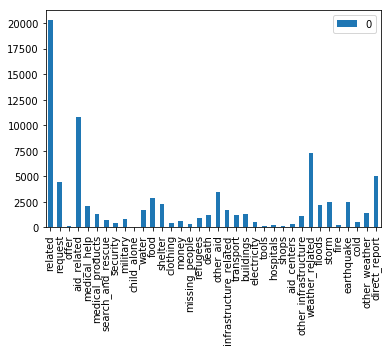

In [60]:
df_count.plot(kind='bar',)

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    
    return tokens



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier())),
])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y.columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [7]:
for x in Y.columns:
    print(x,Y[x].unique())

related [1 0]
request [0 1]
offer [0 1]
aid_related [0 1]
medical_help [0 1]
medical_products [0 1]
search_and_rescue [0 1]
security [0 1]
military [0 1]
child_alone [0]
water [0 1]
food [0 1]
shelter [0 1]
clothing [0 1]
money [0 1]
missing_people [0 1]
refugees [0 1]
death [0 1]
other_aid [0 1]
infrastructure_related [0 1]
transport [0 1]
buildings [0 1]
electricity [0 1]
tools [0 1]
hospitals [0 1]
shops [0 1]
aid_centers [0 1]
other_infrastructure [0 1]
weather_related [0 1]
floods [0 1]
storm [0 1]
fire [0 1]
earthquake [0 1]
cold [0 1]
other_weather [0 1]
direct_report [0 1]


In [8]:
Y = Y.drop(['child_alone'],axis=1)

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

# train classifier
np.random.seed(42)
pipeline.fit(X_train,Y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [10]:
X_train.shape

(19662,)

In [11]:
Y_train.shape

(19662, 35)

In [12]:
Y_pred = pipeline.predict(X_test)

In [13]:
print(classification_report(Y_test.values, Y_pred,target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      5001
               request       0.73      0.46      0.57      1052
                 offer       0.00      0.00      0.00        33
           aid_related       0.73      0.59      0.65      2654
          medical_help       0.58      0.09      0.16       501
      medical_products       0.73      0.12      0.21       332
     search_and_rescue       0.52      0.08      0.14       161
              security       0.12      0.01      0.02       117
              military       0.71      0.10      0.17       228
                 water       0.86      0.35      0.50       404
                  food       0.81      0.51      0.63       692
               shelter       0.76      0.25      0.38       561
              clothing       0.77      0.10      0.18        96
                 money       0.53      0.05      0.10       149
        missing_people       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [14]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__estimator__

In [15]:
start_time = time.time()

parameters = {'vect__min_df': [1, 10],
              'clf__estimator__n_estimators':[10, 20], 
              'clf__estimator__min_samples_split':[2, 5, 10]}


cv = GridSearchCV(pipeline, param_grid = parameters)


np.random.seed(42)
model = cv.fit(X_train, Y_train)


print("Training took %s min ---" % ((time.time() - start_time)/60))

Training took 40.99859714110692 min ---


In [16]:
model

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__min_df': [1, 10], 'clf__estimator__n_estimators': [10, 20], 'clf__estimator__min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
model.best_params_

{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 20,
 'vect__min_df': 10}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [18]:
print(classification_report(Y_test.values, Y_pred,target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      5001
               request       0.73      0.46      0.57      1052
                 offer       0.00      0.00      0.00        33
           aid_related       0.73      0.59      0.65      2654
          medical_help       0.58      0.09      0.16       501
      medical_products       0.73      0.12      0.21       332
     search_and_rescue       0.52      0.08      0.14       161
              security       0.12      0.01      0.02       117
              military       0.71      0.10      0.17       228
                 water       0.86      0.35      0.50       404
                  food       0.81      0.51      0.63       692
               shelter       0.76      0.25      0.38       561
              clothing       0.77      0.10      0.18        96
                 money       0.53      0.05      0.10       149
        missing_people       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
pred_test = model.predict(X_test)

In [20]:
print(classification_report(Y_test.values, pred_test ,target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      5001
               request       0.79      0.48      0.60      1052
                 offer       0.00      0.00      0.00        33
           aid_related       0.73      0.67      0.70      2654
          medical_help       0.47      0.09      0.16       501
      medical_products       0.80      0.15      0.25       332
     search_and_rescue       0.60      0.13      0.21       161
              security       0.40      0.02      0.03       117
              military       0.57      0.11      0.18       228
                 water       0.89      0.45      0.59       404
                  food       0.80      0.64      0.71       692
               shelter       0.76      0.48      0.59       561
              clothing       0.76      0.17      0.27        96
                 money       0.71      0.03      0.06       149
        missing_people       0.75      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [21]:
pipeline_v2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(SVC())),
])
pipeline_v2.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__C', 'clf__estimator__cache_size', 'clf__estimator__class_weight', 'clf__estimator__coef0', 'clf__estimator__decision_function_shape', 'clf__estimator__degree', 'clf__estimator__gamma', 'clf__estimator__kernel', 'clf__estimator__max_iter', 'clf__estimator__probability', 'clf__estimator__random_state', 'clf__estimator__shrinking', 'clf__estimator__tol', 'clf__estimator__verbose', 'clf__estimator', 'clf__n_jobs'])

In [ ]:
start_time = time.time()

parameters_v2 = {
    'vect__max_df': [0.5, 1.0],
    'tfidf__use_idf':[True, False],
    'clf__estimator__kernel': ['rbf','poly'], 
    'clf__estimator__C':[1,5,10]}

cv_v2 = GridSearchCV(pipeline_v2, param_grid = parameters_v2)

np.random.seed(42)
model_v2 = cv_v2.fit(X_train, Y_train)

print("Training took %s min ---" % ((time.time() - start_time)/60))

In [ ]:
pipeline_v2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(algorithm='SAMME'))),
])

pipeline_v2.get_params().keys()

In [ ]:
# 'DecisionTreeClassifier()'

In [ ]:
parameters_v2 = {
    'vect__max_df': [0.5, 1.0],
    'clf__estimator__base_estimator': [SVC()], 
    'clf__estimator__n_estimators':[50, 100]}


cv_v2 = GridSearchCV(pipeline_v2, param_grid = parameters_v2)


np.random.seed(42)
model_v2 = cv_v2.fit(X_train, Y_train)

In [ ]:
model_v2.best_params_

In [ ]:
pred_test = model.predict(X_test)

### 9. Export your model as a pickle file

In [ ]:
pickle.dump(model, open('disaster_model.sav', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.